# Part 1: working with RDD
## 1.1 Data preparation and Loading

1. create Sparkcontext object using SparkSession

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
master = 'local[*]'
app_name = 'ass1'
spark_conf = SparkConf().setAppName(app_name).setMaster(master)
spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [2]:
sc

<SparkContext master=local[*] appName=ass1>

2. Improt Trip into single RDD
3. Import passenger into single RDD

In [3]:
trip_rdd = sc.textFile('data/trip.csv')
passenger_rdd = sc.textFile('data/passenger.csv')


4. For both Trip and Passenger, remove the header rows and display the total count and first 5 records. 

In [4]:
#remove header
tripheader = trip_rdd.first()
trip_rdd_no_header = trip_rdd.filter(lambda x: x != tripheader).map(lambda x: x.split(','))
#first 5 record
trip_rdd_no_header.take(5)


[['a84c0db2',
  'cb64172e',
  '2ea4359d',
  '43006',
  '9/8/2019 10:01:28 PM',
  '9/8/2019 10:15:54 PM',
  '0.3',
  '1.92',
  '4.36'],
 ['a84c2d10',
  '3034e6fe',
  'e1bd0c8d',
  '43006',
  '7/1/2019 8:56:28 PM',
  '7/1/2019 9:22:09 PM',
  '0',
  '9.36',
  '6.91'],
 ['a84c3e75',
  '93fb6802',
  '75e6d450',
  '43050',
  '8/20/2019 9:30:46 PM',
  '8/20/2019 9:46:48 PM',
  '0',
  '4.39',
  '3.48'],
 ['a84c3f6f',
  '25fc9273',
  '5ba48e89',
  '43020',
  '9/8/2019 2:42:41 AM',
  '9/8/2019 2:59:56 AM',
  '0',
  '2.04',
  '1.54'],
 ['a84c5ce2',
  '484c4d0c',
  'fdb2ef59',
  '43006',
  '6/10/2019 9:29:18 AM',
  '6/10/2019 9:55:36 AM',
  '0',
  '7.37',
  '5.83']]

In [5]:
#total count
trip_rdd_no_header.count()

2318357

In [6]:
#remove header
passengerheader = passenger_rdd.first()
passenger_rdd_no_header = passenger_rdd.filter(lambda x: x != passengerheader).map(lambda x: x.split(','))
#first 5 record
passenger_rdd_no_header.take(5)


[['00000fab', '5/11/2019 8:23:54 PM'],
 ['0000149d', '12/24/2018 9:21:33 PM'],
 ['00002b66', '9/20/2018 9:08:24 PM'],
 ['00002bc7', '7/28/2019 11:27:56 AM'],
 ['0000332e', '2/21/2019 11:34:24 PM']]

In [7]:
#total count
passenger_rdd_no_header.count()

1235782

## 1.2 Data Partitioning in RDD 

1. How many partitions do the above RDDs have? How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? 

Round-robin data partitioning,
By default, Spark creates one partition for each block of the file (blocks being 128MB by default in HDFS). Note that you cannot have fewer partitions than blocks.



In [8]:
print("Number of trip partitions:{}".format(trip_rdd_no_header.getNumPartitions()))
print("trip Partitioner:{}".format(trip_rdd_no_header.partitioner))

print("Number of passenger partitions:{}".format(passenger_rdd_no_header.getNumPartitions()))
print("passenger Partitioner:{}".format(passenger_rdd_no_header.partitioner))


Number of trip partitions:6
trip Partitioner:None
Number of passenger partitions:2
passenger Partitioner:None


In [9]:
type(trip_rdd_no_header)

pyspark.rdd.PipelinedRDD

In [10]:
def partitions_details(rdd):
    partitions=rdd.glom().collect() #glom() return records in each partitions
    for index, partition in enumerate(partitions):
        print(f'''Parition{index}: {len(partition)} records
        {partition[0]}''')

In [11]:
partitions_details(trip_rdd_no_header)

Parition0: 380795 records
        ['a84c0db2', 'cb64172e', '2ea4359d', '43006', '9/8/2019 10:01:28 PM', '9/8/2019 10:15:54 PM', '0.3', '1.92', '4.36']
Parition1: 380803 records
        ['21ad8072', '5fdb6f5d', 'd453b272', '43006', '6/13/2019 3:12:24 AM', '6/13/2019 3:44:49 AM', '0', '5.64', '6.87']
Parition2: 380767 records
        ['02c3a31a', '27c169c0', '3e5d58b0', '43179', '7/7/2019 3:07:59 AM', '7/7/2019 3:37:51 AM', '0', '12.28', '7.83']
Parition3: 380796 records
        ['69cb265d', 'af922a73', '7fe5037d', '43116', '7/28/2019 7:27:21 AM', '7/28/2019 7:41:39 AM', '0.4', '2.88', '3.99']
Parition4: 380795 records
        ['d1103efa', '4ab28f66', '0833f475', '43050', '9/15/2019 4:27:46 AM', '9/15/2019 5:13:38 AM', '0', '9.03', '11.92']
Parition5: 414401 records
        ['382ee267', '966448b4', '584d7505', '43050', '6/7/2019 5:58:29 AM', '6/7/2019 6:22:27 AM', '0', '5.51', '3.64']


2. In the “Passenger” csv dataset, there is a column called first_call_time which shows the called time of the passenger. 

- a. Create a Key Value Pair RDD of passenger data, with the key as 'In 2019' or 'Not In 2019' dependent on whether the first call time happened in 2019('first_call_time' column) and the rest of the other columns as the value. After that, print the first 5 records.

- b. Assume we want to keep all the data related to 2019 in one partition and keep the other year’s data in another partition. Write the code to implement this partitioning in RDD using appropriate partitioning functions. (Explain which partition strategy you used?)

- c. Write the code to print the number of records in each partition. 

In [12]:
Passenger_rdd = passenger_rdd_no_header.map(lambda x: (x[1].split(' ')[0]  , x[0]))
Passenger_rdd.take(10)

[('5/11/2019', '00000fab'),
 ('12/24/2018', '0000149d'),
 ('9/20/2018', '00002b66'),
 ('7/28/2019', '00002bc7'),
 ('2/21/2019', '0000332e'),
 ('11/3/2017', '00003af1'),
 ('8/2/2019', '000048aa'),
 ('7/11/2019', '0000497f'),
 ('3/9/2018', '00004a41'),
 ('5/4/2019', '000070ff')]

In [13]:
Passenger_rdd = passenger_rdd_no_header.map(lambda x: ('In 2019' if x[1].split(' ')[0][-4:] == '2019' else 'Not In 2019', x[0]))
Passenger_rdd.take(10)



[('In 2019', '00000fab'),
 ('Not In 2019', '0000149d'),
 ('Not In 2019', '00002b66'),
 ('In 2019', '00002bc7'),
 ('In 2019', '0000332e'),
 ('Not In 2019', '00003af1'),
 ('In 2019', '000048aa'),
 ('In 2019', '0000497f'),
 ('Not In 2019', '00004a41'),
 ('In 2019', '000070ff')]

In [14]:
def range_function(key):
    if key == "In 2019":
        return 0
    else:
        return 1
    
        

In [15]:
partition_Passenger_rdd = Passenger_rdd.partitionBy(2, range_function)

In [16]:
partitions_details(partition_Passenger_rdd)

Parition0: 556856 records
        ('In 2019', '00000fab')
Parition1: 678926 records
        ('Not In 2019', '0000149d')


Since we only want to see the data in 2019 and not in 2019, I set the number of partitions as 2

# 1.3 Query/Analysis (15%)
For the Trip RDD, write relevant RDD operations to answer the following queries.
1. There are 2 columns called "trip_distance" and "surge_rate", which show the distance and surge rate of that trip. Filter the trip RDD which if any column of them is empty. Show the count before and after filtering.


In [17]:
#before
trip_rdd_no_header.count()

2318357

In [18]:
no_empty_trip_rdd_no_header = trip_rdd_no_header.filter(lambda x: (x[6] and x[7])) #use bool to filter

In [19]:
#after
no_empty_trip_rdd_no_header.count()

2295112

2. Calculate the average surge rate for each city. (Hint: you can use 'city_id' directly)


In [20]:
no_empty_trip_rdd_no_header \
    .map(lambda x: (x[3], float(x[6]))) \
    .mapValues(lambda x: (x,1) ) \
    .reduceByKey(lambda x,y :(x[0]+y[0], x[1] + y[1])) \
    .mapValues(lambda x:x[0]/x[1]) \
    .collect()
#Generate a key-value pair RDD   
#count value
#sum the value， and total number of sum
# calculate average

[('43020', 0.03600285427063479),
 ('43050', 0.05545981386673684),
 ('43278', 0.022864212716075583),
 ('43116', 0.059504653033246084),
 ('43006', 0.03495577782547935),
 ('43179', 0.07075066034400256)]

3. Find the driver id who has the max and min trip distance. Also, print out all other trips they made. (Hint: Filter the negative value of trip distance and for the driver who has the min trip distance, only finding one driver is enough for this question)

In [21]:
max_no_empty_trip_rdd_no_header = no_empty_trip_rdd_no_header \
    .max(key = lambda x: x[7])
print('max trip distance is ' + max_no_empty_trip_rdd_no_header[-2])
print('max trip distance driver ID is ' + max_no_empty_trip_rdd_no_header[1])

max trip distance is 99.19
max trip distance driver ID is c11c5e2b


In [22]:
# print out all other trips they made
no_empty_trip_rdd_no_header \
    .filter(lambda x: x[1] == 'c11c5e2b') \
    .collect()

[['383651da',
  'c11c5e2b',
  '7545bdca',
  '43278',
  '9/20/2019 11:45:57 PM',
  '9/21/2019 12:33:18 AM',
  '0',
  '22.31',
  '14.49'],
 ['85ab11bb',
  'c11c5e2b',
  '086dac13',
  '43278',
  '9/17/2019 5:46:13 PM',
  '9/17/2019 5:57:21 PM',
  '0',
  '2.51',
  '3.86'],
 ['8b3ba126',
  'c11c5e2b',
  '8efcd866',
  '43278',
  '5/18/2019 2:07:42 AM',
  '5/18/2019 2:20:55 AM',
  '0',
  '2.73',
  '3.22'],
 ['3b38737f',
  'c11c5e2b',
  '5cf8910e',
  '43278',
  '5/16/2019 1:06:22 AM',
  '5/16/2019 1:19:58 AM',
  '0',
  '3.65',
  '3.01'],
 ['406adbb1',
  'c11c5e2b',
  '7124b5bf',
  '43278',
  '9/23/2019 8:07:02 PM',
  '9/23/2019 8:21:03 PM',
  '0',
  '5.82',
  '6.58'],
 ['7874da3e',
  'c11c5e2b',
  '8c69341a',
  '43278',
  '5/15/2019 9:33:10 PM',
  '5/15/2019 11:18:40 PM',
  '0',
  '99.19',
  '62.7'],
 ['9202f230',
  'c11c5e2b',
  '2742d9cb',
  '43278',
  '5/18/2019 7:18:55 AM',
  '5/18/2019 7:30:29 AM',
  '0',
  '2.33',
  '3.98']]

In [23]:
min_no_empty_trip_rdd_no_header = no_empty_trip_rdd_no_header \
    .filter(lambda x: float(x[7])>0) \
    .min(key = lambda x: x[7])
print('min trip distance is ' + min_no_empty_trip_rdd_no_header[-3])
print('min trip distance driver ID is ' + min_no_empty_trip_rdd_no_header[1])

min trip distance is 0
min trip distance driver ID is 5e3c5726


In [24]:
# print out all other trips they made
no_empty_trip_rdd_no_header \
    .filter(lambda x: x[1] == '5e3c5726') \
    .collect()

[['ab2bd915',
  '5e3c5726',
  'bc087229',
  '43116',
  '7/17/2019 3:25:39 AM',
  '7/17/2019 3:37:08 AM',
  '0',
  '0.01',
  '2.08'],
 ['bb45a0f4',
  '5e3c5726',
  '1f39258a',
  '43116',
  '6/26/2019 10:35:10 PM',
  '6/26/2019 11:01:42 PM',
  '0',
  '7.01',
  '7.15'],
 ['c3306b0d',
  '5e3c5726',
  '4a188b01',
  '43116',
  '5/12/2019 10:56:30 PM',
  '5/12/2019 11:14:26 PM',
  '0',
  '1.53',
  '1.88'],
 ['cbaf135b',
  '5e3c5726',
  'de20a8b3',
  '43116',
  '8/26/2019 8:47:51 PM',
  '8/26/2019 9:06:24 PM',
  '0',
  '6.04',
  '5.19'],
 ['ecdf4be0',
  '5e3c5726',
  'fc8ebd80',
  '43116',
  '6/20/2019 11:55:34 PM',
  '6/21/2019 12:32:09 AM',
  '0',
  '14.97',
  '8.81'],
 ['f86231bb',
  '5e3c5726',
  '2372f81b',
  '43116',
  '7/5/2019 2:23:24 AM',
  '7/5/2019 2:35:59 AM',
  '0',
  '3.66',
  '2.74'],
 ['fe35576e',
  '5e3c5726',
  '9e3cc163',
  '43116',
  '7/7/2019 7:50:22 PM',
  '7/7/2019 8:32:12 PM',
  '0',
  '13.07',
  '6.29'],
 ['010f434d',
  '5e3c5726',
  '7ab60944',
  '43116',
  '7/22/2019

# 2.1 Data Preparation and Loading (5%)
1. Load all trips, passenger, and city data into three separate dataframes. (Hint: you should directly use “inferSchema=True”)


In [25]:
trips = spark.read.csv('data/trip.csv', sep = ',',inferSchema=True, header=True)
#df_trips = trips.toPandas()

passenger = spark.read.csv('data/passenger.csv', sep = ',',inferSchema=True, header=True)
#df_passenger = trips.toPandas()

city = spark.read.csv('data/city.csv', sep = ',',inferSchema=True, header=True)
#df_city = trips.toPandas()


2. Display the schema of the final three dataframes.

In [26]:
trips.printSchema()

root
 |-- id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- call_time: string (nullable = true)
 |-- finish_time: string (nullable = true)
 |-- surge_rate: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_fare: double (nullable = true)



In [27]:
passenger.printSchema()

root
 |-- id: string (nullable = true)
 |-- first_call_time: string (nullable = true)



In [28]:
city.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)



# 2.2 Query/Analysis (15%)
Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API. The following DF means dataframes.
1. Rename ‘id’ in city DF into ‘city_id’.


In [29]:
city = city.withColumnRenamed('id', 'city_id')

In [30]:
city.printSchema()

root
 |-- city_id: integer (nullable = true)
 |-- name: string (nullable = true)



2. Join city DF with trip DF. Delete 'city_id' column and rename 'name' column to 'city' column. (Hint: You should use “inner join”)


In [31]:
city_inner_trip_df= city.join(trips, city.city_id == trips.city_id, how = 'inner') \
    .drop('city_id') \
    .withColumnRenamed('name', 'city')
city_inner_trip_df.show(5)
city_inner_trip_df.printSchema()

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019 9:55:36 AM|       0.0|         7.37|     5.83|
+-------

In [32]:
type(city_inner_trip_df)

pyspark.sql.dataframe.DataFrame

3. Use joined DF above in 2.2.2, keep the rows in which trip_distance and trip_fare is both larger than 0. Show 5 records after filtering.


In [33]:
city_inner_trip_df223 = city_inner_trip_df \
    .filter((city_inner_trip_df.trip_distance > 0) & (city_inner_trip_df.trip_fare > 0))
city_inner_trip_df223.show(5)
city_inner_trip_df223.printSchema()

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019 9:55:36 AM|       0.0|         7.37|     5.83|
+-------

In [34]:
type(city_inner_trip_df223)

pyspark.sql.dataframe.DataFrame

4. Use the filtered DF above in 2.2.3, show top 5 rows using descending order of trip_distance. (‘id’, ‘driver_id’, ‘passenger_id’ and ‘trip_distance’ should be displayed)

In [35]:
city_inner_trip_df224 = city_inner_trip_df223 \
    .select('id', 'driver_id', 'passenger_id', 'trip_distance') \
    .orderBy(city_inner_trip_df223.trip_distance.desc())
city_inner_trip_df224.show(5)
city_inner_trip_df224.printSchema()

+--------+---------+------------+-------------+
|      id|driver_id|passenger_id|trip_distance|
+--------+---------+------------+-------------+
|7f4a1ec5| 704642b5|    771e01b2|        296.1|
|30bb5f34| 7119b481|    d5e5e5d8|       261.71|
|ac1861e1| ceccad76|    2a2f3fc5|       244.82|
|4525a2bf| bdb22ca4|    b7f9f488|       236.14|
|b60c4614| 70b9733e|    09ec3959|       235.42|
+--------+---------+------------+-------------+
only showing top 5 rows

root
 |-- id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- trip_distance: double (nullable = true)



# 2.3 Trip Analysis (35%)
In this section, we want to analyse whether the trip fare is higher during the holiday compared with a normal day. And what do different weekdays affect the number of trips?

Using the DataFrame created in 2.2.2, implement the following queries:
1. Create a new Boolean column named 'On Holiday' to identify whether the trip happened on holiday. If the 'call_time' column is on the following date, then it should be a holiday ('On Holiday' should be true). Print out the latest DF result.
(Hint: You can directly use the String type of 'call_time’ to do this task and udf will be used in this task)
('1/1/2019', '3/5/2019', '4/19/2019', '4/21/2019', '5/1/2019', '6/20/2019', '9/7/2019', '10/12/2019', '11/2/2019', '11/15/2019', '12/25/2019')

In [36]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType
from pyspark.sql.types import IntegerType

In [37]:
def holiday(call_time):
    call_time = call_time.split(' ')[0] # use call_time as str
    holiday_list = ['1/1/2019', '3/5/2019', '4/19/2019', '4/21/2019', '5/1/2019', '6/20/2019', '9/7/2019', \
                          '10/12/2019', '11/2/2019', '11/15/2019', '12/25/2019']
    for i in holiday_list: #check str is in holiday list
        if i == call_time:
            return True
    return False

#holiday_udf = udf(holiday) #only default strtype
holiday_udf = udf(holiday, BooleanType())# creat the udf and change the data type

city_inner_trip_df231 = city_inner_trip_df.withColumn('On Holiday',holiday_udf('call_time'))
city_inner_trip_df231.show(5)


+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+----------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|On Holiday|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+----------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|     false|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|     false|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|     false|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|     false|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019

In [38]:
#check wethere have on holiday is true
city_inner_trip_df231.filter(F.col('On Holiday') == 'true').show()

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+----------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|On Holiday|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+----------+
|      Gondor|a8507640| 331b53d0|    08bbc4e3|9/7/2019 11:06:51 AM|9/7/2019 11:28:46 AM|       0.6|        12.74|    22.85|      true|
|       Rohan|a850dbbd| 25e25247|    2f995965|9/7/2019 12:30:20 PM|9/7/2019 12:39:54 PM|       0.0|         3.31|     2.04|      true|
|Minas Tirith|a858262e| 0d489ecb|    25867a8f| 9/7/2019 7:41:49 PM| 9/7/2019 8:02:48 PM|       0.0|         4.73|     3.94|      true|
|      Gondor|a859ff23| bc323fe4|    47c7b627| 9/7/2019 3:31:42 AM| 9/7/2019 4:04:09 AM|       0.0|         7.95|     6.65|      true|
|      Gondor|a85b17cb| 5ade372a|    0998f41f|6/20/2019

In [39]:
#check data type
city_inner_trip_df231.printSchema()

root
 |-- city: string (nullable = true)
 |-- id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- call_time: string (nullable = true)
 |-- finish_time: string (nullable = true)
 |-- surge_rate: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_fare: double (nullable = true)
 |-- On Holiday: boolean (nullable = true)



2. Observe whether holidays have any effect on the average trip fare in various cities. Your DF’s output should be like the following image. You need to provide 2 implementations that will use both Dataframes and Spark SQL to finish this task.

In [40]:
# dataframe
city_inner_trip_df232 = city_inner_trip_df231.groupBy('city', 'On Holiday') \
    .agg({'trip_fare': 'mean'}) \
    .sort('city', 'On Holiday')
city_inner_trip_df232.show()

+------------+----------+------------------+
|        city|On Holiday|    avg(trip_fare)|
+------------+----------+------------------+
|      Gondor|     false|  5.13122212820313|
|      Gondor|      true|5.4218031555221575|
|    Isengard|     false| 5.550994994344451|
|    Isengard|      true| 5.690277565084232|
|Minas Tirith|     false| 4.969949667768408|
|Minas Tirith|      true|  5.22092199619494|
|   Rivendell|     false| 5.669180818214374|
|   Rivendell|      true| 5.851725862931469|
|       Rohan|     false| 5.276064985963267|
|       Rohan|      true| 5.455164385996093|
|   The Shire|     false| 4.995571570029671|
|   The Shire|      true| 5.189087501615612|
+------------+----------+------------------+



In [41]:
#sql
city_inner_trip_df231.createOrReplaceTempView('city_inner_trip_df231_sql')
spark.sql('''
SELECT city,`on holiday`,AVG(trip_fare)
FROM city_inner_trip_df231_sql
GROUP BY city, `On Holiday`
SORT BY city, `On Holiday`
''').show()

+------------+----------+------------------+
|        city|on holiday|    avg(trip_fare)|
+------------+----------+------------------+
|      Gondor|      true|5.4218031555221575|
|Minas Tirith|      true|  5.22092199619494|
|   Rivendell|      true| 5.851725862931469|
|       Rohan|     false| 5.276064985963267|
|   The Shire|      true| 5.189087501615612|
|      Gondor|     false|  5.13122212820313|
|       Rohan|      true| 5.455164385996093|
|Minas Tirith|     false| 4.969949667768408|
|   The Shire|     false| 4.995571570029671|
|    Isengard|     false| 5.550994994344451|
|   Rivendell|     false| 5.669180818214374|
|    Isengard|      true| 5.690277565084232|
+------------+----------+------------------+



3. Use Dataframe created in 2.2.2. Create a new column called 'weekday' which transfers the 'call_time' column to 'MON,'TUE','WED'... Print out the top 5 rows in the output. (Try to use “to_date" to get full marks, otherwise, you will lose some marks and udf will be used in this task)

In [42]:
def weekday(call_time):
    call_time = call_time.split(' ')[0]
    return call_time
weekday_udf = udf(weekday)

In [43]:
city_inner_trip_df233 = city_inner_trip_df.withColumn('weekday',F.upper(F.date_format(F.to_date(weekday_udf('call_time'),'M/d/y'), 'EEE')))
city_inner_trip_df233.show(5)

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+-------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|weekday|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+-------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|    SUN|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|    MON|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|    TUE|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|    SUN|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019

4. Based on the Dataframe we created in 2.3.3. Compute the total number of the trip (number of rows) for each weekday in different cities and the percentage for the 7 different weekdays. Your output should be like the following image. (Hint: udf will be used in this task)

In [44]:
#creat a city_count list
city_list=city_inner_trip_df233.groupBy("city").count().collect()
print(city_list)
print(type(city_list))

[Row(city='Rivendell', count=388464), Row(city='The Shire', count=489454), Row(city='Gondor', count=318499), Row(city='Rohan', count=365397), Row(city='Minas Tirith', count=418895), Row(city='Isengard', count=337648)]
<class 'list'>


In [45]:
#use key_value pair to create udf
def counts(data):
    city = data
    for i in city_list:
        if i[0] == city:
            return i[1]
count_udf = udf(counts, IntegerType())    



        

In [46]:
city_inner_trip_df234 = city_inner_trip_df233 \
    .groupBy('city','weekday') \
    .agg(F.count('city').alias('count')) \
    .withColumn('percentage', F.col('count')/count_udf(F.col('city'))) \
    .drop('count') \
    .sort('city','weekday')
city_inner_trip_df234.show()
city_inner_trip_df234.printSchema()



+------------+-------+-------------------+
|        city|weekday|         percentage|
+------------+-------+-------------------+
|      Gondor|    FRI|0.14324377784545633|
|      Gondor|    MON|0.14286387084417848|
|      Gondor|    SAT|0.16049343953984158|
|      Gondor|    SUN| 0.1656363128298676|
|      Gondor|    THU| 0.1337743603590592|
|      Gondor|    TUE| 0.1255733926951105|
|      Gondor|    WED| 0.1284148458864863|
|    Isengard|    FRI|0.14602485428612047|
|    Isengard|    MON| 0.1297890110410842|
|    Isengard|    SAT|0.17138262332369805|
|    Isengard|    SUN|0.16508612519546983|
|    Isengard|    THU|0.13720205657963322|
|    Isengard|    TUE|0.12160593280576222|
|    Isengard|    WED|0.12890939676823202|
|Minas Tirith|    FRI|0.14613686007233317|
|Minas Tirith|    MON|0.12856682462192195|
|Minas Tirith|    SAT|0.16618961792334594|
|Minas Tirith|    SUN|0.16084937752897505|
|Minas Tirith|    THU| 0.1369531744231848|
|Minas Tirith|    TUE|0.12791510999176406|
+----------

5. Draw a bar chart using ‘city’, ‘weekday’, and ‘Percentage’ we generated in 2.3.4 using matplotlib. Discuss what effect dose different weekdays made on the number of trips in different cities?

In [47]:
from matplotlib import pyplot

In [48]:
pandas = city_inner_trip_df234.toPandas()

In [49]:
pandas

,city,weekday,percentage
0,Gondor,FRI,0.143244
1,Gondor,MON,0.142864
2,Gondor,SAT,0.160493
3,Gondor,SUN,0.165636
4,Gondor,THU,0.133774
5,Gondor,TUE,0.125573
6,Gondor,WED,0.128415
7,Isengard,FRI,0.146025
8,Isengard,MON,0.129789
9,Isengard,SAT,0.171383


In [50]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html
pandas = pandas.pivot(index='city', columns='weekday', values='percentage')

In [51]:
pandas

weekday,FRI,MON,SAT,SUN,THU,TUE,WED
city,,,,,,,
Gondor,0.143244,0.142864,0.160493,0.165636,0.133774,0.125573,0.128415
Isengard,0.146025,0.129789,0.171383,0.165086,0.137202,0.121606,0.128909
Minas Tirith,0.146137,0.128567,0.166190,0.160849,0.136953,0.127915,0.133389
Rivendell,0.136504,0.150719,0.164787,0.179734,0.125631,0.119226,0.123399
Rohan,0.144084,0.143351,0.163192,0.168359,0.131906,0.123633,0.125474
The Shire,0.150760,0.124471,0.170210,0.151920,0.141478,0.126151,0.135010


Text(0.5, 1.0, 'city_week_%')

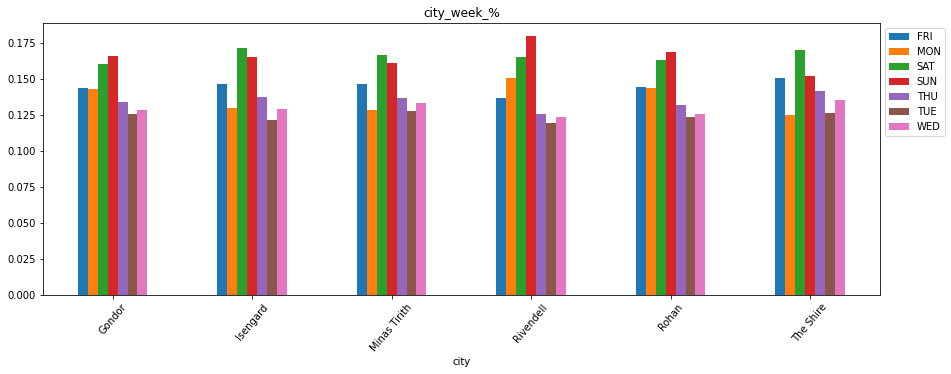

In [52]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
axes = pandas.plot.bar(figsize = (15,5),rot=50)
pyplot.legend(loc='best', bbox_to_anchor=(1, 1))
pyplot.title("city_week_%") 

# Part3: RDDs vs DataFrame vs Spark SQL (15%)
Implement the following queries using RDDs, DataFrames and SparkSQL separately. Log the time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these 3 approaches.
Note: Students could research and/or think of other ways to compare the performance of the 3 approaches rather than rely on the "%%time" command.

Query: Join the trip and city csv based on 'city_id', only keep all the data in 'Minas Tirith' city, show id of trip, city name, and call time in the output.

In [53]:
city_rdd = sc.textFile('data/city.csv')
cityheader = city_rdd.first()
city_rdd_no_header = city_rdd.filter(lambda x: x != cityheader).map(lambda x: x.split(','))
#first 5 record
city_rdd.take(5)


['id,name',
 '42868,Mordor',
 '42948,Erebor',
 '43006,Minas Tirith',
 '43020,Isengard']

In [54]:
trip_rdd.take(2)

['id,driver_id,passenger_id,city_id,call_time,finish_time,surge_rate,trip_distance,trip_fare',
 'a84c0db2,cb64172e,2ea4359d,43006,9/8/2019 10:01:28 PM,9/8/2019 10:15:54 PM,0.3,1.92,4.36']

In [55]:
trip_rdd_no_header \
    .map(lambda x: (x[3],x)) \
    .join(city_rdd_no_header.map(lambda x: (x[0],x))).take(2)

[('43006',
  (['a84c0db2',
    'cb64172e',
    '2ea4359d',
    '43006',
    '9/8/2019 10:01:28 PM',
    '9/8/2019 10:15:54 PM',
    '0.3',
    '1.92',
    '4.36'],
   ['43006', 'Minas Tirith'])),
 ('43006',
  (['a84c2d10',
    '3034e6fe',
    'e1bd0c8d',
    '43006',
    '7/1/2019 8:56:28 PM',
    '7/1/2019 9:22:09 PM',
    '0',
    '9.36',
    '6.91'],
   ['43006', 'Minas Tirith']))]

In [56]:
%%time
part3_RDD =trip_rdd_no_header \
    .map(lambda x: (x[3],x)) \
    .join(city_rdd_no_header.map(lambda x: (x[0],x))) \
    .filter(lambda x: x[1][1][1] == 'Minas Tirith') \
    .map(lambda x: (x[1][0][0],x[1][1][1], x[1][0][4]))
part3_RDD.collect()

CPU times: user 177 ms, sys: 37.3 ms, total: 215 ms
Wall time: 30.2 s


[('a84c0db2', 'Minas Tirith', '9/8/2019 10:01:28 PM'),
 ('a84c2d10', 'Minas Tirith', '7/1/2019 8:56:28 PM'),
 ('a84c5ce2', 'Minas Tirith', '6/10/2019 9:29:18 AM'),
 ('a84ceb22', 'Minas Tirith', '6/30/2019 3:09:18 AM'),
 ('a84d29a0', 'Minas Tirith', '8/11/2019 9:49:49 PM'),
 ('a84d31ee', 'Minas Tirith', '7/7/2019 11:53:51 PM'),
 ('a84d8d16', 'Minas Tirith', '6/24/2019 7:25:16 AM'),
 ('a84dbd8a', 'Minas Tirith', '7/1/2019 9:56:52 PM'),
 ('a84dc20a', 'Minas Tirith', '6/13/2019 2:42:58 AM'),
 ('a84dfcb7', 'Minas Tirith', '7/27/2019 6:19:44 PM'),
 ('a84f80fa', 'Minas Tirith', '8/2/2019 8:17:11 PM'),
 ('a84fc521', 'Minas Tirith', '5/14/2019 4:48:25 AM'),
 ('a850834f', 'Minas Tirith', '7/30/2019 8:37:40 AM'),
 ('a850c3de', 'Minas Tirith', '8/12/2019 12:49:33 PM'),
 ('a850de4c', 'Minas Tirith', '6/4/2019 10:49:11 PM'),
 ('a851b2b2', 'Minas Tirith', '8/28/2019 10:52:48 PM'),
 ('a8528280', 'Minas Tirith', '8/27/2019 6:51:21 AM'),
 ('a852a3b2', 'Minas Tirith', '8/31/2019 4:36:57 AM'),
 ('a8530202

In [57]:
from pyspark.sql.functions import broadcast

In [58]:
%%time
part3_df=trips \
    .join(broadcast(city), trips.city_id==city.city_id  , how = 'inner') \
    .filter(F.col('name') == 'Minas Tirith') \
    .select('id', 'name', 'call_time')
part3_df.collect()

CPU times: user 2.14 s, sys: 54 ms, total: 2.19 s
Wall time: 6 s


[Row(id='a84c0db2', name='Minas Tirith', call_time='9/8/2019 10:01:28 PM'),
 Row(id='a84c2d10', name='Minas Tirith', call_time='7/1/2019 8:56:28 PM'),
 Row(id='a84c5ce2', name='Minas Tirith', call_time='6/10/2019 9:29:18 AM'),
 Row(id='a84ceb22', name='Minas Tirith', call_time='6/30/2019 3:09:18 AM'),
 Row(id='a84d29a0', name='Minas Tirith', call_time='8/11/2019 9:49:49 PM'),
 Row(id='a84d31ee', name='Minas Tirith', call_time='7/7/2019 11:53:51 PM'),
 Row(id='a84d8d16', name='Minas Tirith', call_time='6/24/2019 7:25:16 AM'),
 Row(id='a84dbd8a', name='Minas Tirith', call_time='7/1/2019 9:56:52 PM'),
 Row(id='a84dc20a', name='Minas Tirith', call_time='6/13/2019 2:42:58 AM'),
 Row(id='a84dfcb7', name='Minas Tirith', call_time='7/27/2019 6:19:44 PM'),
 Row(id='a84f80fa', name='Minas Tirith', call_time='8/2/2019 8:17:11 PM'),
 Row(id='a84fc521', name='Minas Tirith', call_time='5/14/2019 4:48:25 AM'),
 Row(id='a850834f', name='Minas Tirith', call_time='7/30/2019 8:37:40 AM'),
 Row(id='a850c3

In [59]:
# Create Views from Dataframes
trips.createOrReplaceTempView("sql_trips")

city.createOrReplaceTempView("sql_city")

In [60]:
%%time
part3_sql = spark.sql('''
  SELECT t.id, c.name, t.call_time
  FROM sql_trips t JOIN sql_city c
  ON t.city_id == c.city_id
  WHERE name == 'Minas Tirith'
''')
part3_sql.collect()

CPU times: user 2.21 s, sys: 28.8 ms, total: 2.24 s
Wall time: 5.78 s


[Row(id='a84c0db2', name='Minas Tirith', call_time='9/8/2019 10:01:28 PM'),
 Row(id='a84c2d10', name='Minas Tirith', call_time='7/1/2019 8:56:28 PM'),
 Row(id='a84c5ce2', name='Minas Tirith', call_time='6/10/2019 9:29:18 AM'),
 Row(id='a84ceb22', name='Minas Tirith', call_time='6/30/2019 3:09:18 AM'),
 Row(id='a84d29a0', name='Minas Tirith', call_time='8/11/2019 9:49:49 PM'),
 Row(id='a84d31ee', name='Minas Tirith', call_time='7/7/2019 11:53:51 PM'),
 Row(id='a84d8d16', name='Minas Tirith', call_time='6/24/2019 7:25:16 AM'),
 Row(id='a84dbd8a', name='Minas Tirith', call_time='7/1/2019 9:56:52 PM'),
 Row(id='a84dc20a', name='Minas Tirith', call_time='6/13/2019 2:42:58 AM'),
 Row(id='a84dfcb7', name='Minas Tirith', call_time='7/27/2019 6:19:44 PM'),
 Row(id='a84f80fa', name='Minas Tirith', call_time='8/2/2019 8:17:11 PM'),
 Row(id='a84fc521', name='Minas Tirith', call_time='5/14/2019 4:48:25 AM'),
 Row(id='a850834f', name='Minas Tirith', call_time='7/30/2019 8:37:40 AM'),
 Row(id='a850c3

# rdd
- CPU times: user 222 ms, sys: 25.3 ms, total: 247 ms

- Wall time: 31.5 s

# df
- CPU times: user 2.3 s, sys: 49.1 ms, total: 2.34 s

- Wall time: 6.35 s

# sql

- CPU times: user 2.38 s, sys: 73.2 ms, total: 2.45 s

- Wall time: 5.34 s

compare with 3 methods, we can see rdd use the most time to solve the result, most time spend is in user，but think about sys time, rdd is use the least time. The best is use sql, wall time is 5.34, but with the most time in sys time. for the whole three methods, i recommand to use df or sql, these two are faster than use rdd, if u consider the cup time, choose df, if consider the wall time, use sql